## Diffusion (DDPM) on Sneakers

Trains a diffusion model on the same `data/` sneakers dataset and preprocessing as `GAN_pytorch.ipynb`.

In [1]:
%%bash

if [ ! -d data/ ]; then
    curl -sO 'https://courses.cv-gml.ru/storage/tasks/sneaker-generation/data.zip'
    unzip -qo data.zip
fi

In [2]:
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = torch.device(_device)

torch.manual_seed(0)

### 1. Sneakers dataset

In [3]:
class SneakersDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images_dir="images",
        input_size=None,
        target_size=None,
        use_rgb: bool=False,
        root_dir: str="data",
    ):
        self.images_dir = os.path.join(root_dir, images_dir)
        self.input_size = input_size
        self.target_size = target_size
        self.use_rgb = use_rgb
        files = os.listdir(self.images_dir)
        self.all_images = sorted([file for file in files if file.endswith(".jpg")])

    def __len__(self):
        return len(self.all_images)

    def _read_image(self, image_path: str, size):
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            raise FileNotFoundError(image_path)

        if self.use_rgb:
            image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            if size is not None:
                image = cv2.resize(image, size)
            image = (image.astype(np.float32) / 255.0) * 2.0 - 1.0
            return torch.from_numpy(image).permute(2, 0, 1)

        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        if size is not None:
            image = cv2.resize(image, size)
        image = (image.astype(np.float32) / 255.0) * 2.0 - 1.0
        return torch.from_numpy(image).unsqueeze(0)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.all_images[idx])

        if self.input_size is not None:
            x_in = self._read_image(image_path, self.input_size)
            x_tgt = self._read_image(image_path, self.target_size)
            return x_in, x_tgt

        x = self._read_image(image_path, self.target_size)
        return x, 0


def data2img(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().float().numpy()
    x = 0.5 * x + 0.5
    return np.clip(x, 0.0, 1.0)


def to_display(x):
    x = data2img(x)
    if x.ndim == 3 and x.shape[0] in (1, 3):
        x = np.transpose(x, (1, 2, 0))
    if x.ndim == 3 and x.shape[2] == 1:
        x = x[:, :, 0]
    return x


def visualize_images(dataset, n_rows, n_cols, seed=0):
    n_samples = n_rows * n_cols

    rng = np.random.default_rng(seed)
    if len(dataset) >= n_samples:
        sample_indices = rng.choice(len(dataset), n_samples, replace=False)
    else:
        sample_indices = rng.choice(len(dataset), n_samples, replace=True)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        item = dataset[int(sample_index)]
        x = item[0] if isinstance(item, (tuple, list)) else item
        x = to_display(x)
        if x.ndim == 2:
            plt.imshow(x, cmap="gray")
        else:
            plt.imshow(x)
        plt.axis("off")
    plt.show()

In [4]:
# visualize dataset

full_dataset = SneakersDataset(target_size=(128,128), use_rgb=True)

n_total = len(full_dataset)
n_test = max(1, int(0.1 * n_total))
n_train = n_total - n_test

g = torch.Generator().manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [n_train, n_test],
    generator=g,
)

len(train_dataset), len(test_dataset)

(5157, 572)

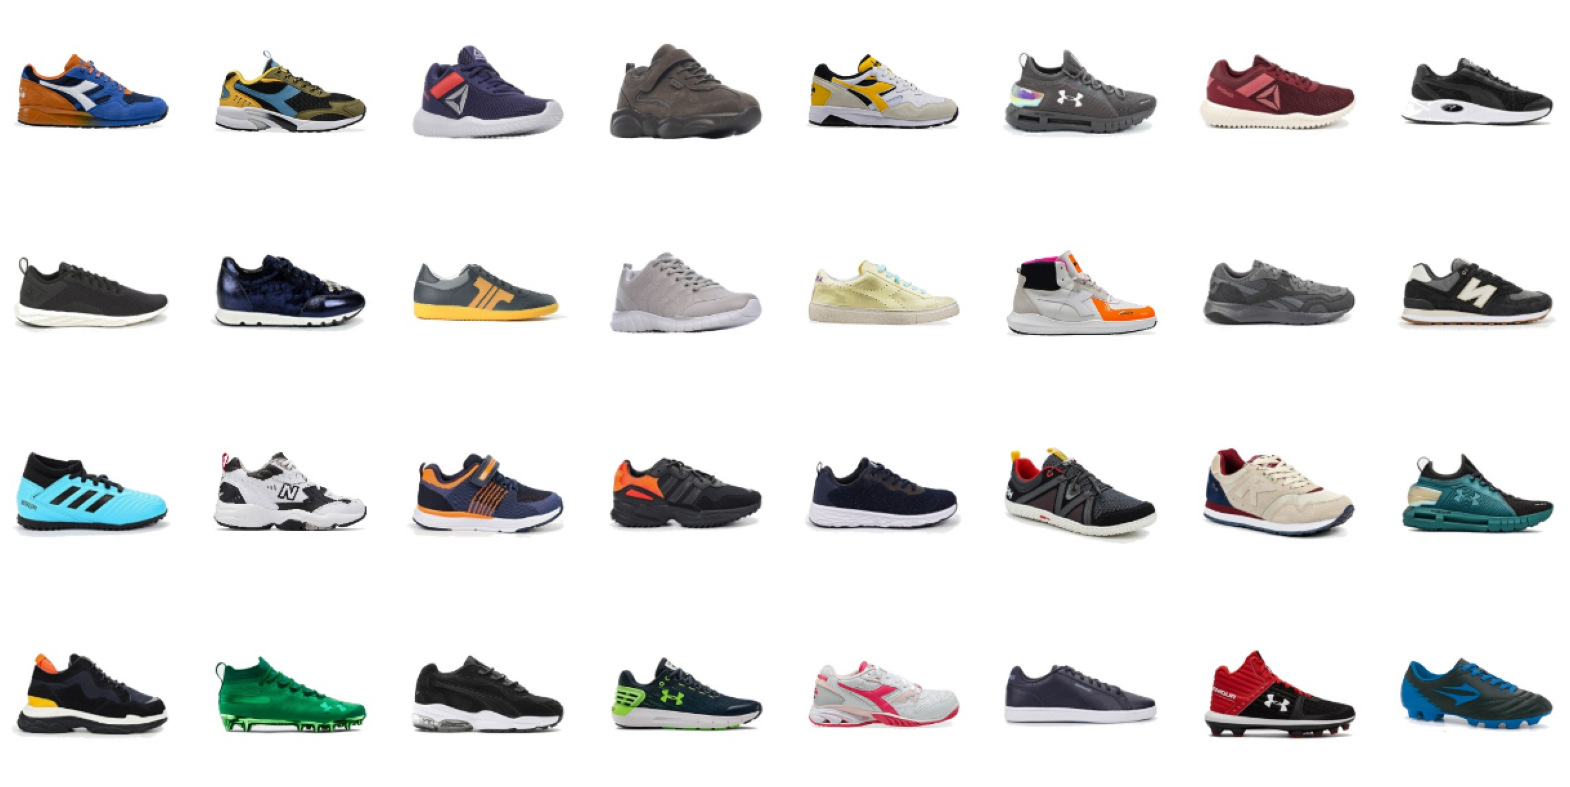

In [5]:
visualize_images(train_dataset, 4, 8, seed=0)

### 2. Model: Unet w/ Attention

In [6]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim

    def forward(self, t):
        # TODO 1: Get the device from input tensor t
        # Hint: Use t.device
        device = t.device
        
        # TODO 2: Calculate half_dim (we create sin and cos embeddings separately)
        # Hint: Divide emb_dim by 2
        half_dim = self.emb_dim // 2

        # TODO 3: Create geometric freq
        # This creates a geometric series of frequencies for each half of embedding (sin/cos)
        emb_power = torch.arange(half_dim, device=device) / (half_dim - 1)
        emb = 10_000.0 ** (-emb_power)
        
        # TODO 4: Multiply timesteps by frequencies (outer product)
        # Hint: t[:, None].float() * emb[None, :]
        # Shape: [batch_size, half_dim]
        emb = t[:, None].float() * emb[None, :]
        
        # TODO 5: Apply sin and cos, then concatenate
        # Hint: torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        # Final shape: [batch_size, emb_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        
        return emb

In [7]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=2, padding=1, padding_mode="reflect"
        )

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

In [8]:
class DDPMResAttnBlock(nn.Module):
    """
    Residual + Attention block with time embedding via FiLM conditioning.

      ResNet: GN -> SiLU -> Conv -> +time -> GN -> SiLU -> Conv -> +skip
      Attn:   reshape -> GN -> MHA -> reshape -> +skip
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, use_attn=True):
        super().__init__()
        self.use_attn = use_attn
        self.nonlinearity = nn.SiLU()

        # TODO: First conv path (GN -> SiLU -> Conv in->out)
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        # TODO: Time embedding projection (SiLU -> Linear t_emb_dim->out_channels)
        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2)
        )

        # TODO: Second conv path (GN -> SiLU -> Conv out->out)
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        # TODO: Residual skip (1x1 Conv in->out OR Identity if you want)
        self.skip_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # TODO: Attention modules (GroupNorm + MultiheadAttention with embed_dim=out_channels)
        if self.use_attn:
            self.attn_norm = nn.GroupNorm(8, out_channels)
            self.mha = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, x, t_emb):
        h = x

        # TODO: ResNet part: conv_1
        h = self.conv_1(h)

        # TODO: Use FiLM
        t_emb = self.time_proj(t_emb)
        scale, shift = t_emb.chunk(2, dim=1)
        scale = scale.unsqueeze(-1).unsqueeze(-1)
        shift = shift.unsqueeze(-1).unsqueeze(-1)
        h = (1 + scale) * h + shift

        # TODO: ResNet part: conv_2
        h = self.conv_2(h)

        # TODO: Residual add
        h = h + self.skip_conn(x)

        if self.use_attn:
            # TODO: Attention part
            B, C, H, W = h.shape
            a = h.view(B, C, -1)  # (B, C, H*W)
            a = self.attn_norm(a).permute(0, 2, 1)  # (B, C, H*W) -> (B, H*W, C)
            a, _ = self.mha(a, a, a)
            a = a.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, H*W, C) -> (B, H, W, C) -> (B, C, H, W)
            h = h + a

        return h

In [9]:
class UnetDiffusionModel(nn.Module):
    def __init__(
        self,
        emb_dim=128,
        time_steps=1000,
        dropout=0.1,
        num_heads=4,
        use_attention=False,
        n_channels=1,
        image_size=(28,28)
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.time_steps = time_steps
        self.n_channels = n_channels
        self.image_size = image_size
        self.nonlinearity = nn.SiLU()

        self.time_emb = SinusoidalTimeEmbedding(emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            self.nonlinearity,
            nn.Linear(emb_dim * 4, emb_dim),
        )

        self.conv_in = nn.Conv2d(n_channels, 32, kernel_size=3, padding=1, padding_mode="reflect")

        self.enc1 = DDPMResAttnBlock(32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.enc2 = DDPMResAttnBlock(32, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.mid = DDPMResAttnBlock(64, 128, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.dec3 = DDPMResAttnBlock(64 + 64, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.dec2 = DDPMResAttnBlock(32 + 32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)

        self.down1 = Downsample(32, 32)   # 28->14
        self.down2 = Downsample(64, 64)   # 14->7

        self.up3 = Upsample(128, 64)      # 7->14, 128->64
        self.up2 = Upsample(64, 32)       # 14->28, 64->32

        self.conv_out = nn.Conv2d(32, n_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(self.time_emb(t))
        if x.ndim == 3:
            x = x.unsqueeze(0)
        elif x.ndim == 2:
            x = x.view(-1, self.n_channels, self.image_size[0], self.image_size[1])

        h = self.conv_in(x)

        e1 = self.enc1(h, t_emb)
        h = self.down1(e1)

        e2 = self.enc2(h, t_emb)
        h = self.down2(e2)

        h = self.mid(h, t_emb)

        h = self.up3(h)
        h = torch.cat([h, e2], dim=1)
        h = self.dec3(h, t_emb)

        h = self.up2(h)
        h = torch.cat([h, e1], dim=1)
        h = self.dec2(h, t_emb)

        return self.conv_out(h)

In [10]:
def visualize_reconstruction_samples(
    model,
    sample_fn,
    alpha_bar,
    time_steps,
    epoch,
    k=5,
    seed=42,
    dataset=None,
    t_noise=150
):
    """Visualize k reconstructed samples: original, noised at t_noise, and reconstructed."""
    if dataset is None:
        dataset = train_dataset

    torch.manual_seed(seed)
    np.random.seed(seed)

    device = next(model.parameters()).device

    indices = np.random.choice(len(dataset), k, replace=False)
    original_images = []
    x_0_list = []
    for idx in indices:
        img, _ = dataset[idx]
        original_images.append(to_display(img))
        x_0_list.append(img)

    x_0 = torch.stack(x_0_list).to(device)
    ab_t = alpha_bar[t_noise].view(-1, 1, 1, 1)
    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(ab_t) * x_0 + torch.sqrt(1 - ab_t) * eps
    noised_images = x_t.cpu().numpy()

    reconstructed = sample_fn(model, n_samples=k, num_steps=t_noise + 1, x_init=x_t)
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(3, k, figsize=(2 * k, 6))

    for i in range(k):
        x0_disp = original_images[i]
        if x0_disp.ndim == 2:
            axes[0, i].imshow(x0_disp, cmap="gray")
        else:
            axes[0, i].imshow(x0_disp)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original", fontsize=10)

        xt_disp = to_display(noised_images[i])
        if xt_disp.ndim == 2:
            axes[1, i].imshow(xt_disp, cmap="gray")
        else:
            axes[1, i].imshow(xt_disp)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title(f"Noised (t={t_noise})", fontsize=10)

        xr_disp = to_display(reconstructed[i])
        if xr_disp.ndim == 2:
            axes[2, i].imshow(xr_disp, cmap="gray")
        else:
            axes[2, i].imshow(xr_disp)
        axes[2, i].axis("off")
        if i == 0:
            axes[2, i].set_title("Reconstructed", fontsize=10)

    plt.suptitle(f"Reconstruction (Epoch {epoch}, t={t_noise})", fontsize=12)
    plt.tight_layout()
    return fig

In [11]:
import math

def visualize_generation_samples(model, sample_fn, time_steps, epoch, k=9, seed=42):
    """Visualize k unconditional generations from pure noise in a sqrt(k) x sqrt(k) grid."""
    torch.manual_seed(seed)
    cols = math.isqrt(k)
    rows = math.ceil(k / cols)
    plot_size = 2
    fig, axes = plt.subplots(rows, cols, figsize=(plot_size * cols, plot_size * rows))
    axes = np.array(axes).reshape(rows, cols)

    generated = sample_fn(model, n_samples=k, num_steps=time_steps)
    generated = generated.cpu().numpy()

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < k:
                x = to_display(generated[idx])
                if x.ndim == 2:
                    axes[i, j].imshow(x, cmap="gray")
                else:
                    axes[i, j].imshow(x)
            axes[i, j].axis("off")

    plt.suptitle(f"Generated Samples (Epoch {epoch})", fontsize=12)
    plt.tight_layout()
    return fig

In [12]:
from tqdm.notebook import tqdm

@torch.no_grad()
def visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=42, percentages=None):
    """
    Visualize estimated x_0 and denoised x_{t-1} at fixed percentages of timesteps.
    
    Args:
        model: The diffusion model
        sample_fn: Sampling function that returns intermediate states
        time_steps: Total number of timesteps
        epoch: Current epoch number for title label
        seed: Random seed for reproducibility
        percentages: List of percentages of timesteps to visualize (default: every 25% including 100%)
    """
    if percentages is None:
        percentages = [0, 25, 50, 75, 100]
    
    device = next(model.parameters()).device
    
    # Set seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Get a random validation image
    idx = np.random.randint(0, len(train_dataset))
    x_0_original, _ = train_dataset[idx]
    x_0_original = x_0_original.unsqueeze(0).to(device)
    
    # Compute timesteps from percentages (reversed since we go from T to 0)
    # Clamp to valid range [0, time_steps - 1]
    timestep_indices = [max(0, min(time_steps - 1, int((100 - p) / 100 * (time_steps - 1)))) for p in percentages]
    
    # Use sample_fn to get intermediate states
    # We need to collect x_0 estimates and x_{t-1} at specific timesteps
    x_0_estimates, x_t_minus_1_samples = sample_fn(
        model, 
        n_samples=1, 
        num_steps=time_steps,
        return_intermediates=True,
        intermediate_steps=timestep_indices
    )
    
    n_cols = len(percentages) + 1  # +1 for original image column
    fig, axes = plt.subplots(2, n_cols, figsize=(2 * n_cols, 4))
    
    for col, (pct, t_val) in enumerate(tqdm(zip(percentages, timestep_indices), total=len(percentages), desc="Visualizing")):
        x_0_pred = x_0_estimates[col]
        x_t_minus_1 = x_t_minus_1_samples[col]
        
        # Plot estimated x_0 (top row)
        x = to_display(x_0_pred[0])
        if x.ndim == 2:
            axes[0, col].imshow(x, cmap="gray")
        else:
            axes[0, col].imshow(x)
        axes[0, col].axis('off')
        axes[0, col].set_title(f't={t_val} ({pct}%)', fontsize=9)
        
        # Plot x_{t-1} (bottom row)
        x = to_display(x_t_minus_1[0])
        if x.ndim == 2:
            axes[1, col].imshow(x, cmap="gray")
        else:
            axes[1, col].imshow(x)
        axes[1, col].axis('off')
    
    # Add original image in the last column (both rows)
    original_img = to_display(x_0_original[0])
    if original_img.ndim == 2:
        axes[0, -1].imshow(original_img, cmap="gray")
    else:
        axes[0, -1].imshow(original_img)
    axes[0, -1].axis('off')
    axes[0, -1].set_title('Original', fontsize=9)

    if original_img.ndim == 2:
        axes[1, -1].imshow(original_img, cmap="gray")
    else:
        axes[1, -1].imshow(original_img)
    axes[1, -1].axis('off')
    
    # Add y-axis labels on the left side with more margin
    axes[0, 0].text(-0.3, 0.5, r'$x_0$', transform=axes[0, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    axes[1, 0].text(-0.3, 0.5, r'$x_{t-1}$', transform=axes[1, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    
    plt.suptitle(f'Generation Visualization - Epoch {epoch}', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)
    return fig

In [13]:
def train_step(model, x_0, optimizer, time_steps, alpha_bar, device):
    """
    Single training step for diffusion model.
    
    Args:
        model: The diffusion model
        x_0: Clean images from dataset [batch_size, 1, 28, 28]
        optimizer: The optimizer
    
    Returns:
        loss value
    """
    optimizer.zero_grad()

    batch_size = x_0.shape[0]
    
    # TODO: Sample a batch of random timesteps
    t = torch.randint(0, time_steps, (batch_size,)).to(device)
    
    # TODO: Sample a batch of noise
    epsilon = torch.randn_like(x_0)
    
    # TODO: Compute diffused image x_t using one-step formula for forward diffusion process
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1) # TODO: make alpha_bar[t] broadcastable to [batch_size, 1, 28, 28]
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * epsilon
    
    # TODO: Predict noise using model
    epsilon_pred = model(x_t, t)
    
    # TODO: Compute loss (MSE between predicted and actual noise)
    loss = F.mse_loss(epsilon_pred, epsilon)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [14]:
@torch.no_grad()
def sample(
    model,
    n_samples,
    beta,
    alpha,
    alpha_bar,
    device,
    num_steps=None,
    return_intermediates=False,
    intermediate_steps=None,
    x_init=None,
):
    model.eval()

    if num_steps is None:
        num_steps = len(alpha_bar)
    num_steps = int(num_steps)

    beta = beta[:num_steps]
    alpha = alpha[:num_steps]
    alpha_bar = alpha_bar[:num_steps]

    if x_init is not None:
        x_t = x_init
    else:
        x_t = torch.randn(n_samples, N_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1], device=device)

    if return_intermediates:
        if intermediate_steps is None:
            intermediate_steps = []
        step_set = set(intermediate_steps)
        x0_by_step = {}
        xprev_by_step = {}

    for t in reversed(range(num_steps)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long, device=device)

        # TODO: Predict noise using model
        eps_pred = model(x_t, t_batch)

        alpha_t = alpha[t]
        beta_t = beta[t]
        alpha_bar_t = alpha_bar[t]
        ab = alpha_bar_t.view(-1, 1, 1, 1)
        ab_prev = alpha_bar[t-1].view(-1, 1, 1, 1)

        # TODO: Compute mean of p(x_{t-1} | x_t)
        mean = (x_t - (beta_t / torch.sqrt(1 - ab)) * eps_pred) / torch.sqrt(alpha_t)

        # TODO: Add noise (except for t=0)
        if t > 0:
            noise = torch.randn_like(x_t)
            posterior_std = torch.sqrt(beta_t * (1 - ab_prev) / (1 - ab))
            x_prev = mean + posterior_std * noise
        else:
            x_prev = mean

        # x_prev = mean

        if return_intermediates and t in step_set:
            x0_pred = (x_t - torch.sqrt(1 - ab) * eps_pred) / torch.sqrt(ab)
            x0_by_step[t] = x0_pred.detach()
            xprev_by_step[t] = x_prev.detach()

        x_t = x_prev

    model.train()

    if return_intermediates:
        x0_list = [x0_by_step[t] for t in intermediate_steps]
        xprev_list = [xprev_by_step[t] for t in intermediate_steps]
        return x0_list, xprev_list

    return x_prev

In [15]:
# Training hyperparameters

# # Grayscale, (28, 28)
# USE_RGB = False
# IMAGE_SIZE = (28, 28)
# NUM_EPOCHS = 80
# CONTINUE_TRAINING = False
# USE_ATTENTION = False
# BATCH_SIZE = 128

# # RGB, (28, 28)
# USE_RGB = True
# IMAGE_SIZE = (28, 28)
# NUM_EPOCHS = 240
# CONTINUE_TRAINING = False
# USE_ATTENTION = False
# BATCH_SIZE = 128

# RGB, (64, 64)
USE_RGB = True
IMAGE_SIZE = (64, 64)
BASE_CHANNELS = 64
NUM_EPOCHS = 240
CONTINUE_TRAINING = False
USE_ATTENTION = False
BATCH_SIZE = 128

# # RGB, (64, 64) - attention
# USE_RGB = True
# IMAGE_SIZE = (64, 64)
# NUM_EPOCHS = 240
# CONTINUE_TRAINING = False
# USE_ATTENTION = True
# BATCH_SIZE = 32 # not tested, might OOM

TIMESTEPS = 200
LR = 2e-4

In [16]:
@torch.no_grad()
def ema_update(ema_model, model, decay=0.999):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)

EMA_MODEL_DECAY = 0.999

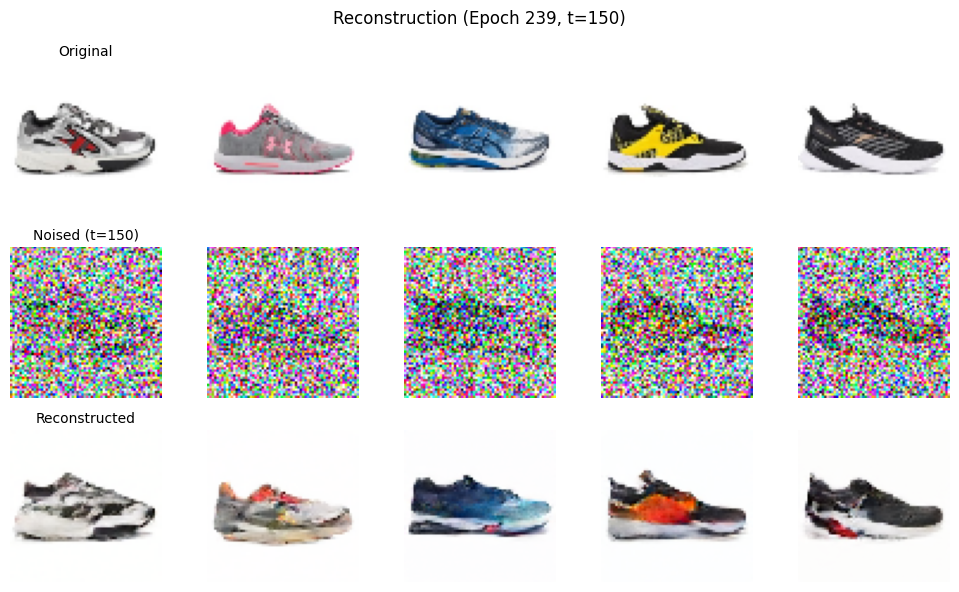

Visualizing: 100%|██████████| 5/5 [00:00<00:00, 416.28it/s]


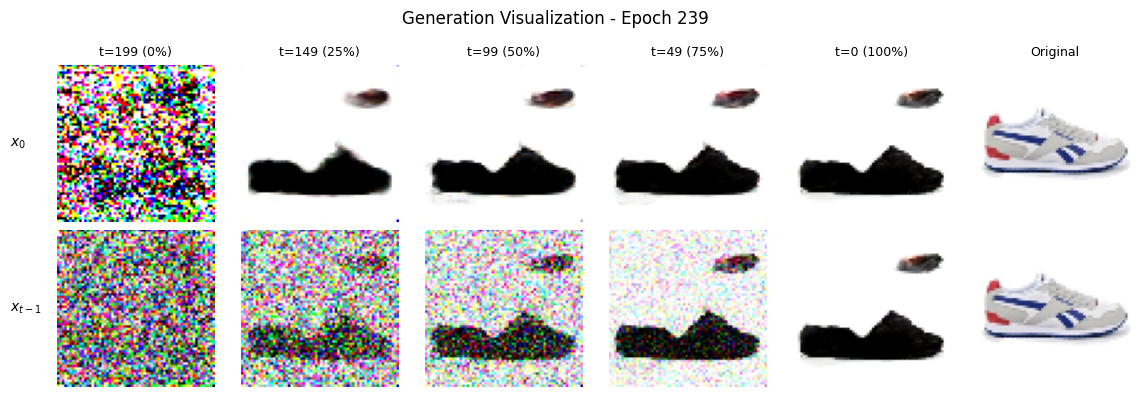

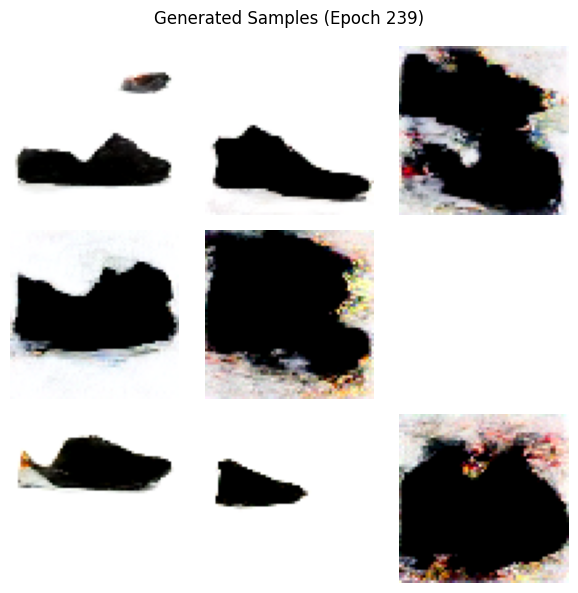

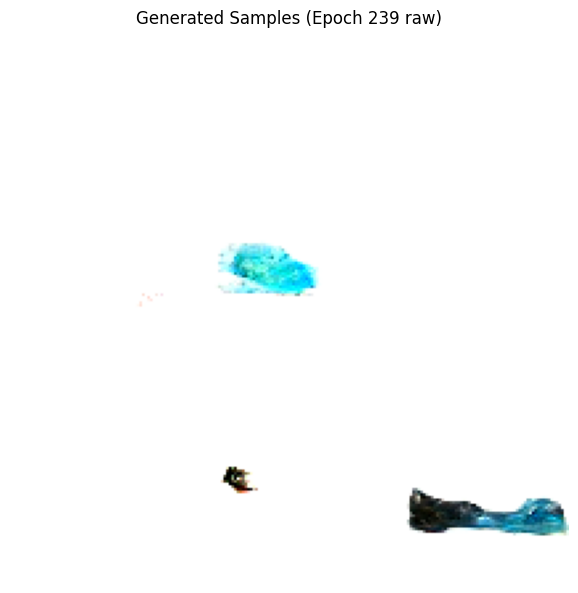

Epochs: 100%|██████████| 240/240 [1:21:00<00:00, 20.25s/it]

Model: UnetDiffusionModel | Params: 811,363 (trainable: 811,363)
Epoch 239/239 completed. Train Loss: 0.0218 | Test Loss: 0.0313 | Epoch Time: 15.37s


In [17]:
# Training loop

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os
import time
import copy

N_CHANNELS = 3 if USE_RGB else 1

# Setup optimizer
model = UnetDiffusionModel(
    n_channels=N_CHANNELS,
    image_size=IMAGE_SIZE,
    time_steps=TIMESTEPS,
    use_attention=USE_ATTENTION,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Cosine beta schedule
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)

beta = cosine_beta_schedule(TIMESTEPS)

alpha = 1 - beta
alpha_bar = torch.cumprod(torch.tensor(alpha, dtype=torch.float32), dim=0).to(device)
beta_tensor = torch.tensor(beta, dtype=torch.float32).to(device)
alpha_tensor = torch.tensor(alpha, dtype=torch.float32).to(device)

# Create directory for saving models
os.makedirs("data/experiments/sneakers", exist_ok=True)

# Load pretrained model if continue_training is True
model_class_name = model.__class__.__name__
model_dir = f"data/experiments/sneakers/{model_class_name}"
pretrained_path = f"{model_dir}/model_latest.pth"
ema_path = f"{model_dir}/model_ema.pth"

if CONTINUE_TRAINING and os.path.exists(pretrained_path):
    print(f"Loading pretrained model from {pretrained_path}")
    model.load_state_dict(torch.load(pretrained_path, map_location=device))
    print("Pretrained model loaded successfully!")
elif CONTINUE_TRAINING:
    print(f"Warning: continue_training=True but no pretrained model found at {pretrained_path}")
    print("Starting training from scratch.")

ema_model = copy.deepcopy(model)
if CONTINUE_TRAINING and os.path.exists(ema_path):
    ema_model.load_state_dict(torch.load(ema_path, map_location=device))
ema_model.eval()

def sample_fn(model, n_samples, num_steps, return_intermediates=False, intermediate_steps=None, x_init=None):
    return sample(
        model,
        n_samples=n_samples,
        beta=beta_tensor,
        alpha=alpha_tensor,
        alpha_bar=alpha_bar,
        device=device,
        num_steps=num_steps,
        return_intermediates=return_intermediates,
        intermediate_steps=intermediate_steps,
        x_init=x_init,
    )

# Precompute number of model parameters
num_params = sum(p.numel() for p in model.parameters())
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, ema_model, train_dataloader, test_dataloader, num_epochs, skip_initial_viz=False):
    model.train()
    model_class_name = model.__class__.__name__
    model_dir = f"data/experiments/sneakers/{model_class_name}"
    gen_samples_dir = f"{model_dir}/viz/gen_samples"
    gen_samples_raw_dir = f"{model_dir}/viz/gen_samples_raw"
    gen_timeline_dir = f"{model_dir}/viz/gen_timeline"
    recon_samples_dir = f"{model_dir}/viz/recon_samples"
    os.makedirs(gen_samples_dir, exist_ok=True)
    os.makedirs(gen_samples_raw_dir, exist_ok=True)
    os.makedirs(gen_timeline_dir, exist_ok=True)
    os.makedirs(recon_samples_dir, exist_ok=True)

    # Save initial (untrained) model visualizations as epoch -1
    print(f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})")
    
    if not skip_initial_viz:
        print("Samples from initial (untrained) model:")
        
        ema_model.eval()
        fig = visualize_reconstruction_samples(ema_model, sample_fn, alpha_bar, TIMESTEPS, epoch=-1, k=5)
        fig.savefig(f"{recon_samples_dir}/-1.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        ema_model.eval()
        fig = visualize_generation_timeline(ema_model, sample_fn, TIMESTEPS, epoch=-1, seed=42)
        fig.savefig(f"{gen_timeline_dir}/-1.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        ema_model.eval()
        fig = visualize_generation_samples(ema_model, sample_fn, TIMESTEPS, epoch=-1)
        fig.savefig(f"{gen_samples_dir}/-1.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        model.eval()
        fig = visualize_generation_samples(model, sample_fn, TIMESTEPS, epoch="-1 raw")
        fig.savefig(f"{gen_samples_raw_dir}/-1.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)
    else:
        print("Continuing training from pretrained model, skipping initial visualization.")

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_start_time = time.time()
        total_loss = 0
        num_batches = 0

        model.train()
        for batch_idx, (x_0, _) in enumerate(train_dataloader):
            x_0 = x_0.to(device)

            loss = train_step(model, x_0, optimizer, TIMESTEPS, alpha_bar, device)
            total_loss += loss
            num_batches += 1

            ema_update(ema_model, model, decay=EMA_MODEL_DECAY)

        avg_train_loss = total_loss / num_batches
        
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        with torch.no_grad():
            for batch_idx, (x_0, _) in enumerate(test_dataloader):
                x_0 = x_0.to(device)
                t = torch.randint(0, TIMESTEPS, (x_0.shape[0],), device=device)
                noise = torch.randn_like(x_0)
                alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
                x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
                predicted_noise = model(x_t, t)
                test_loss = torch.nn.functional.mse_loss(predicted_noise, noise)
                total_test_loss += test_loss.item()
                num_test_batches += 1
        avg_test_loss = total_test_loss / num_test_batches
        
        epoch_train_time = time.time() - epoch_start_time

        torch.save(model.state_dict(), f"{model_dir}/model_latest.pth")
        torch.save(ema_model.state_dict(), f"{model_dir}/model_ema.pth")

        clear_output(wait=True)

        ema_model.eval()
        fig = visualize_reconstruction_samples(ema_model, sample_fn, alpha_bar, TIMESTEPS, epoch, k=5)
        fig.savefig(f"{recon_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        ema_model.eval()
        fig = visualize_generation_timeline(ema_model, sample_fn, TIMESTEPS, epoch, seed=42)
        fig.savefig(f"{gen_timeline_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        ema_model.eval()
        fig = visualize_generation_samples(ema_model, sample_fn, TIMESTEPS, epoch)
        fig.savefig(f"{gen_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        model.eval()
        fig = visualize_generation_samples(model, sample_fn, TIMESTEPS, epoch=f"{epoch} raw")
        fig.savefig(f"{gen_samples_raw_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        print(f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})")
        print(f"Epoch {epoch}/{num_epochs-1} completed. Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Epoch Time: {epoch_train_time:.2f}s")

# (Re)create datasets using current IMAGE_SIZE / USE_RGB
full_dataset = SneakersDataset(target_size=IMAGE_SIZE, use_rgb=USE_RGB)

n_total = len(full_dataset)
n_test = max(1, int(0.1 * n_total))
n_train = n_total - n_test

g = torch.Generator().manual_seed(0)
train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [n_train, n_test],
    generator=g,
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train(model, ema_model, train_loader, test_loader, NUM_EPOCHS, skip_initial_viz=CONTINUE_TRAINING)